Los pasos realizados con la Resnet 34 serán análogos a los de la Resnet 18

In [1]:
import fastai
import torch
from fastai.vision import *
from shutil import copyfile
plt.rcParams.update({'font.size': 18})




In [2]:
dic = {
      'ATYPICAL_LYMPHOCYTE':[],
      'VARIANT_LYMPHOCYTE':[],
      'BLAST':[]
     }

## Se crean los directorios de células de CanRuti

In [3]:
def print_dirs_recursively(root_dir):
    root_dir = os.path.abspath(root_dir)

    for item in os.listdir(root_dir):
        item_full_path = os.path.join(root_dir, item)
        if os.path.isdir(item_full_path):
            print_dirs_recursively(item_full_path)
        else: 
            if '/SLPC/' in item_full_path:
                dic['ATYPICAL_LYMPHOCYTE'].append(item_full_path)
            if '/REACTIUS/' in item_full_path:
                dic['VARIANT_LYMPHOCYTE'].append(item_full_path)
            if '/LA/' in item_full_path:
                dic['BLAST'].append(item_full_path)

print_dirs_recursively('/shared/can_ruti')

In [4]:
#for item in dic.values():
#    for path in item:
#
#        if '/SLPC/' in path:
#            filename = os.path.basename(path)
#            copyfile(path, os.path.join("/shared/Classification_CanRuti/ATYPICAL_LYMPHOCYTE", filename))
#      
#        if '/REACTIUS/' in path:
#            filename = os.path.basename(path)
#            copyfile(path, os.path.join("/shared/Classification_CanRuti/VARIANT_LYMPHOCYTE", filename))
#            
#        if '/LA/' in path:
#            filename = os.path.basename(path)
#            copyfile(path, os.path.join("/shared/Classification_CanRuti/BLAST", filename))            
#                    
#
#

#### Descripción del Conjunto de datos de validación de Can Ruti

In [5]:
folder_1 = os.listdir("/shared/Datasets_Classification/Classification_CanRuti/ATYPICAL_LYMPHOCYTE")
folder_2 = os.listdir("/shared/Datasets_Classification/Classification_CanRuti/VARIANT_LYMPHOCYTE")
folder_3 = os.listdir("/shared/Datasets_Classification/Classification_CanRuti/BLAST")
dic_Classif = {
      'ATYPICAL_LYMPHOCYTE':len(folder_1),
      'VARIANT_LYMPHOCYTE':len(folder_2),
      'BLAST':len(folder_3)
     }

pd.DataFrame(dic_Classif, index=['N'])

ATYPICAL_LYMPHOCYTE  VARIANT_LYMPHOCYTE  BLAST
N                   47                  57     80

In [6]:
folder_classes = "/shared/Datasets_Classification/Classification_CanRuti"
tfms = get_transforms(flip_vert=True, max_warp=None, max_zoom=1.01, max_rotate=120, max_lighting=0.1)





#### Creación de DataBunch

In [7]:
data = (ImageList.from_folder(folder_classes) #Where to find the data? -> in path and its subfolders
        .split_by_rand_pct(0.5,seed=4)           #How to split in train/valid? -> use the folders
        .label_from_folder()            #How to label? -> depending on the folder of the filenames
        .transform(tfms, size=224)       #Data augmentation? -> use tfms with a size of 64
        .databunch()
        .normalize(imagenet_stats))   

In [8]:
data.batch_size = 20

#### Descripción de conjuntos `train` y `valid` (validation set será el `test`)

In [9]:
pd.DataFrame.from_dict({'Number of classes':[data.c],
'train_size':[len(data.train_ds)],
'valid_size':[len(data.valid_ds)]},
orient = 'index', columns=['N'])

N
Number of classes   3
train_size         92
valid_size         92

#### Descripción del reparto de clases en cada set

`Train set`

In [10]:
train_ds = data.train_ds.to_df()
pd.DataFrame(train_ds['y'].value_counts()).rename(columns={'y':'N'})

N
BLAST                43
VARIANT_LYMPHOCYTE   27
ATYPICAL_LYMPHOCYTE  22

`Validation set`

In [11]:
valid_ds = data.valid_ds.to_df()
pd.DataFrame(valid_ds['y'].value_counts()).rename(columns={'y':'N'})

N
BLAST                37
VARIANT_LYMPHOCYTE   30
ATYPICAL_LYMPHOCYTE  25

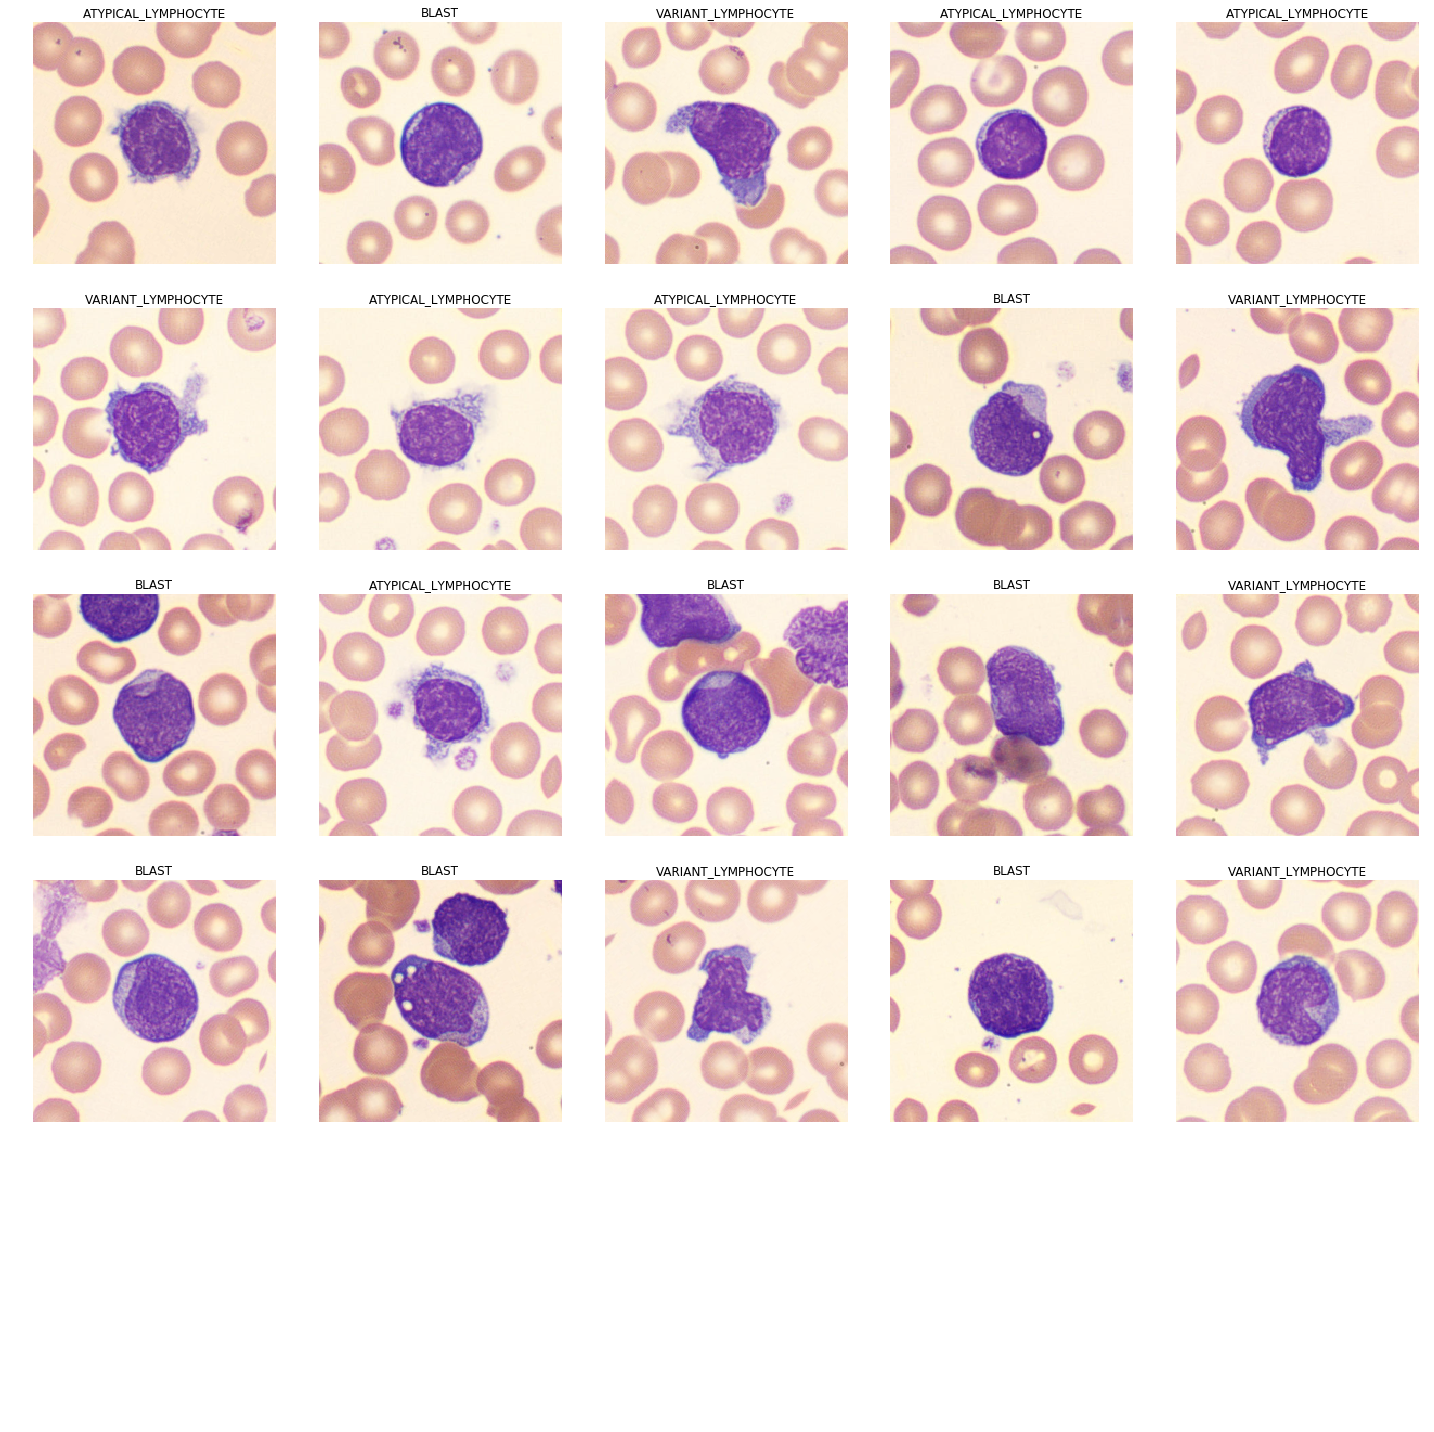

In [12]:
data.show_batch()

In [13]:
folder_model = "/shared/Datasets_Classification/Classification_Clinic_Balanced"


# Test Canruti Resnet 18 Focal Loss Preentrenada en Clinic

Se crea un learner con datos auxilares del clinic pero se sustituye con el Databunch de CanRuti anterior para validar en CanRuti. Nótese que se incorporan los pesos del clínic con el método `.load()`

In [14]:
learn = None
learn = load_learner(folder_model, 'export_stage-2-18-Clinic_Focal_3_Classes')
learn.data = data

Estadísticas de la validación den CanRuti

In [15]:

results = learn.validate(data.valid_dl)
results
valid_CanRuti = dict(zip(['valid_loss', 'error_rate', 'accuracy'],
                         [results[0], results[1].item(),results[2].item()]))

pd.DataFrame(valid_CanRuti, index = ['metrics'])

valid_loss  error_rate  accuracy
metrics    2.928407    0.543478  0.456522

In [16]:
plt.rcParams.update({'font.size': 18})

from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from sklearn.metrics import precision_score, recall_score

def multiclass_roc_auc_score(y_test, y_pred, average="micro"):
    lb = preprocessing.LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)

val_preds,val_targets = learn.get_preds() 

y_test = pd.Series(np.array(val_preds.max(1)[1])).map(dict(zip([0,1,2],learn.data.classes)))
y_true = pd.Series(np.array(val_targets)).map(dict(zip([0,1,2],learn.data.classes)))


precision = precision_score(y_test, y_true, average='micro')
recall = recall_score(y_test, y_true, average='micro')

pd.DataFrame({#'multiclass_roc_auc_score': multiclass_roc_auc_score(y_test, y_true),
             'precision':precision,
             'recall':recall,
             }, index = ['metrics'])

precision    recall
metrics   0.456522  0.456522

`Matriz de confusión` de la validación en Can Ruti

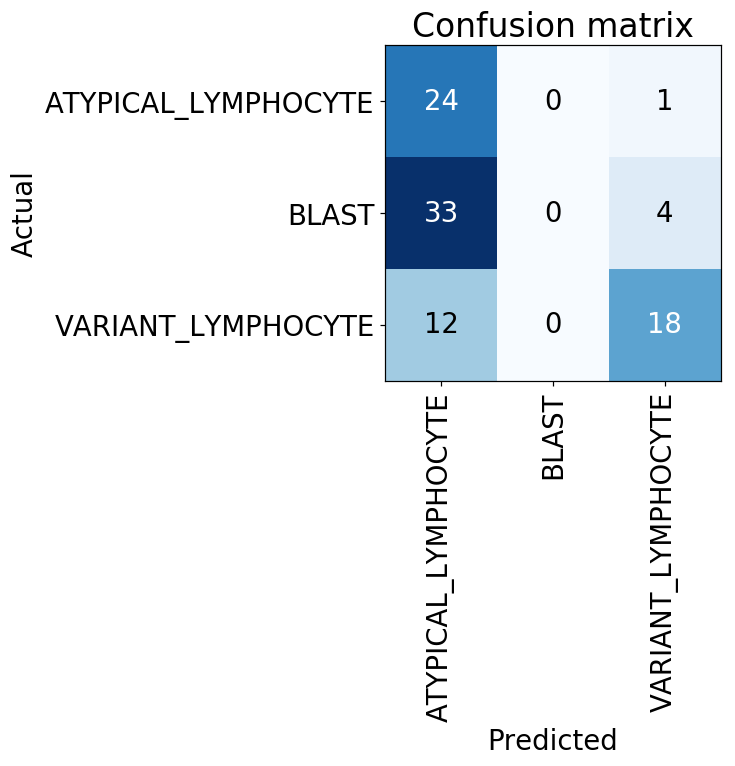

In [26]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
interp.plot_confusion_matrix(figsize=(7,7), dpi=110)

`Matriz de confusión normalizada` de la validación en Can Ruti

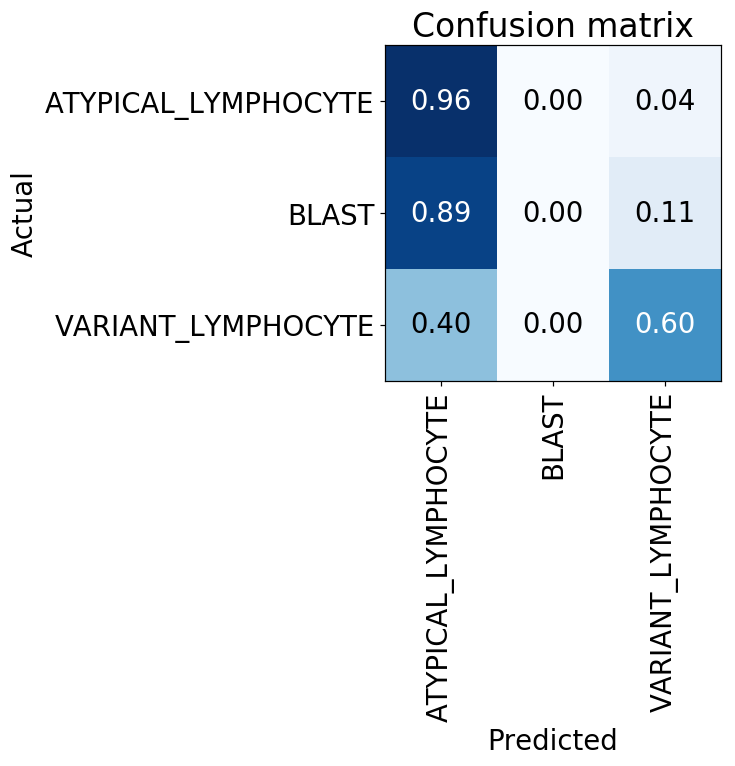

In [27]:
interp.plot_confusion_matrix(figsize=(7,7), dpi=110, normalize=True)

In [28]:
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

#### Fine Tuning en el conjunto de CanRuti

In [18]:
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=3e-4)

In [19]:
learn.fit_one_cycle(2, max_lr=3e-4)

In [20]:
learn.fit_one_cycle(2, max_lr=3e-5)

In [21]:
learn.fit_one_cycle(2, max_lr=3e-5)

In [22]:
plt.rcParams.update({'font.size': 18})

from sklearn.metrics import roc_auc_score
from sklearn import preprocessing

def multiclass_roc_auc_score(y_test, y_pred, average="micro"):
    lb = preprocessing.LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)

val_preds,val_targets = learn.get_preds() 
y_test = pd.Series(np.array(val_preds.max(1)[1])).map(dict(zip([0,1,2],learn.data.classes)))
y_true = pd.Series(np.array(val_targets)).map(dict(zip([0,1,2],learn.data.classes)))
pd.DataFrame({'multiclass_roc_auc_score': multiclass_roc_auc_score(y_test, y_true)}, index = ['metrics'])

multiclass_roc_auc_score
metrics                  0.975543

In [23]:
learn.export('export_stage-2-18-CanRuti_Focal_3_Classes')

In [24]:
interp = ClassificationInterpretation.from_learner(learn)

interp.most_confused(min_val=2)

[('VARIANT_LYMPHOCYTE', 'ATYPICAL_LYMPHOCYTE', 3)]

`Matriz de confusión` tras el fine tuning en Can Ruti

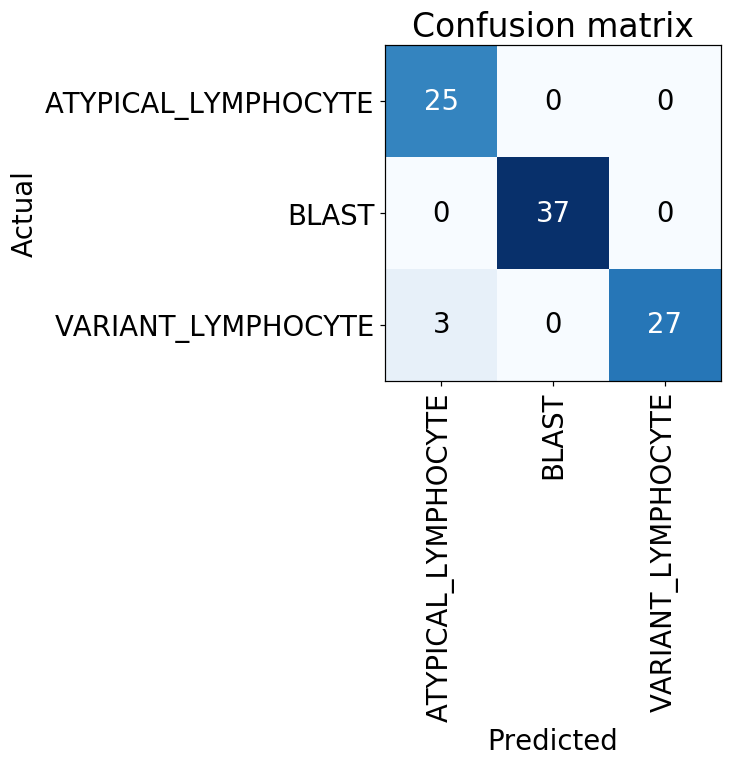

In [27]:
interp.plot_confusion_matrix(figsize=(7,7), dpi=110)

`Matriz de confusión Normalizada` tras el fine tuning en Can Ruti

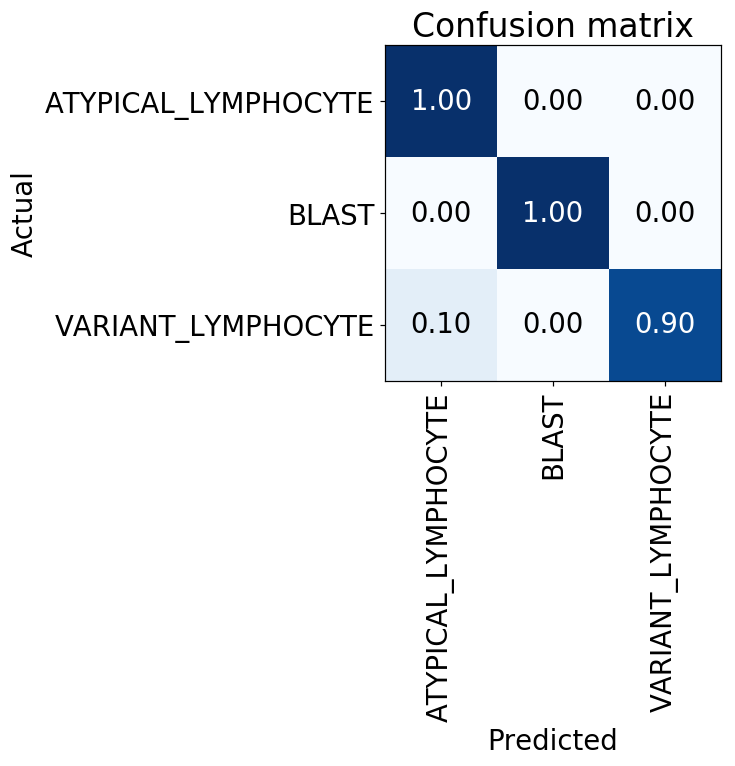

In [28]:
interp.plot_confusion_matrix(figsize=(7,7), dpi=110, normalize=True)

In [29]:
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

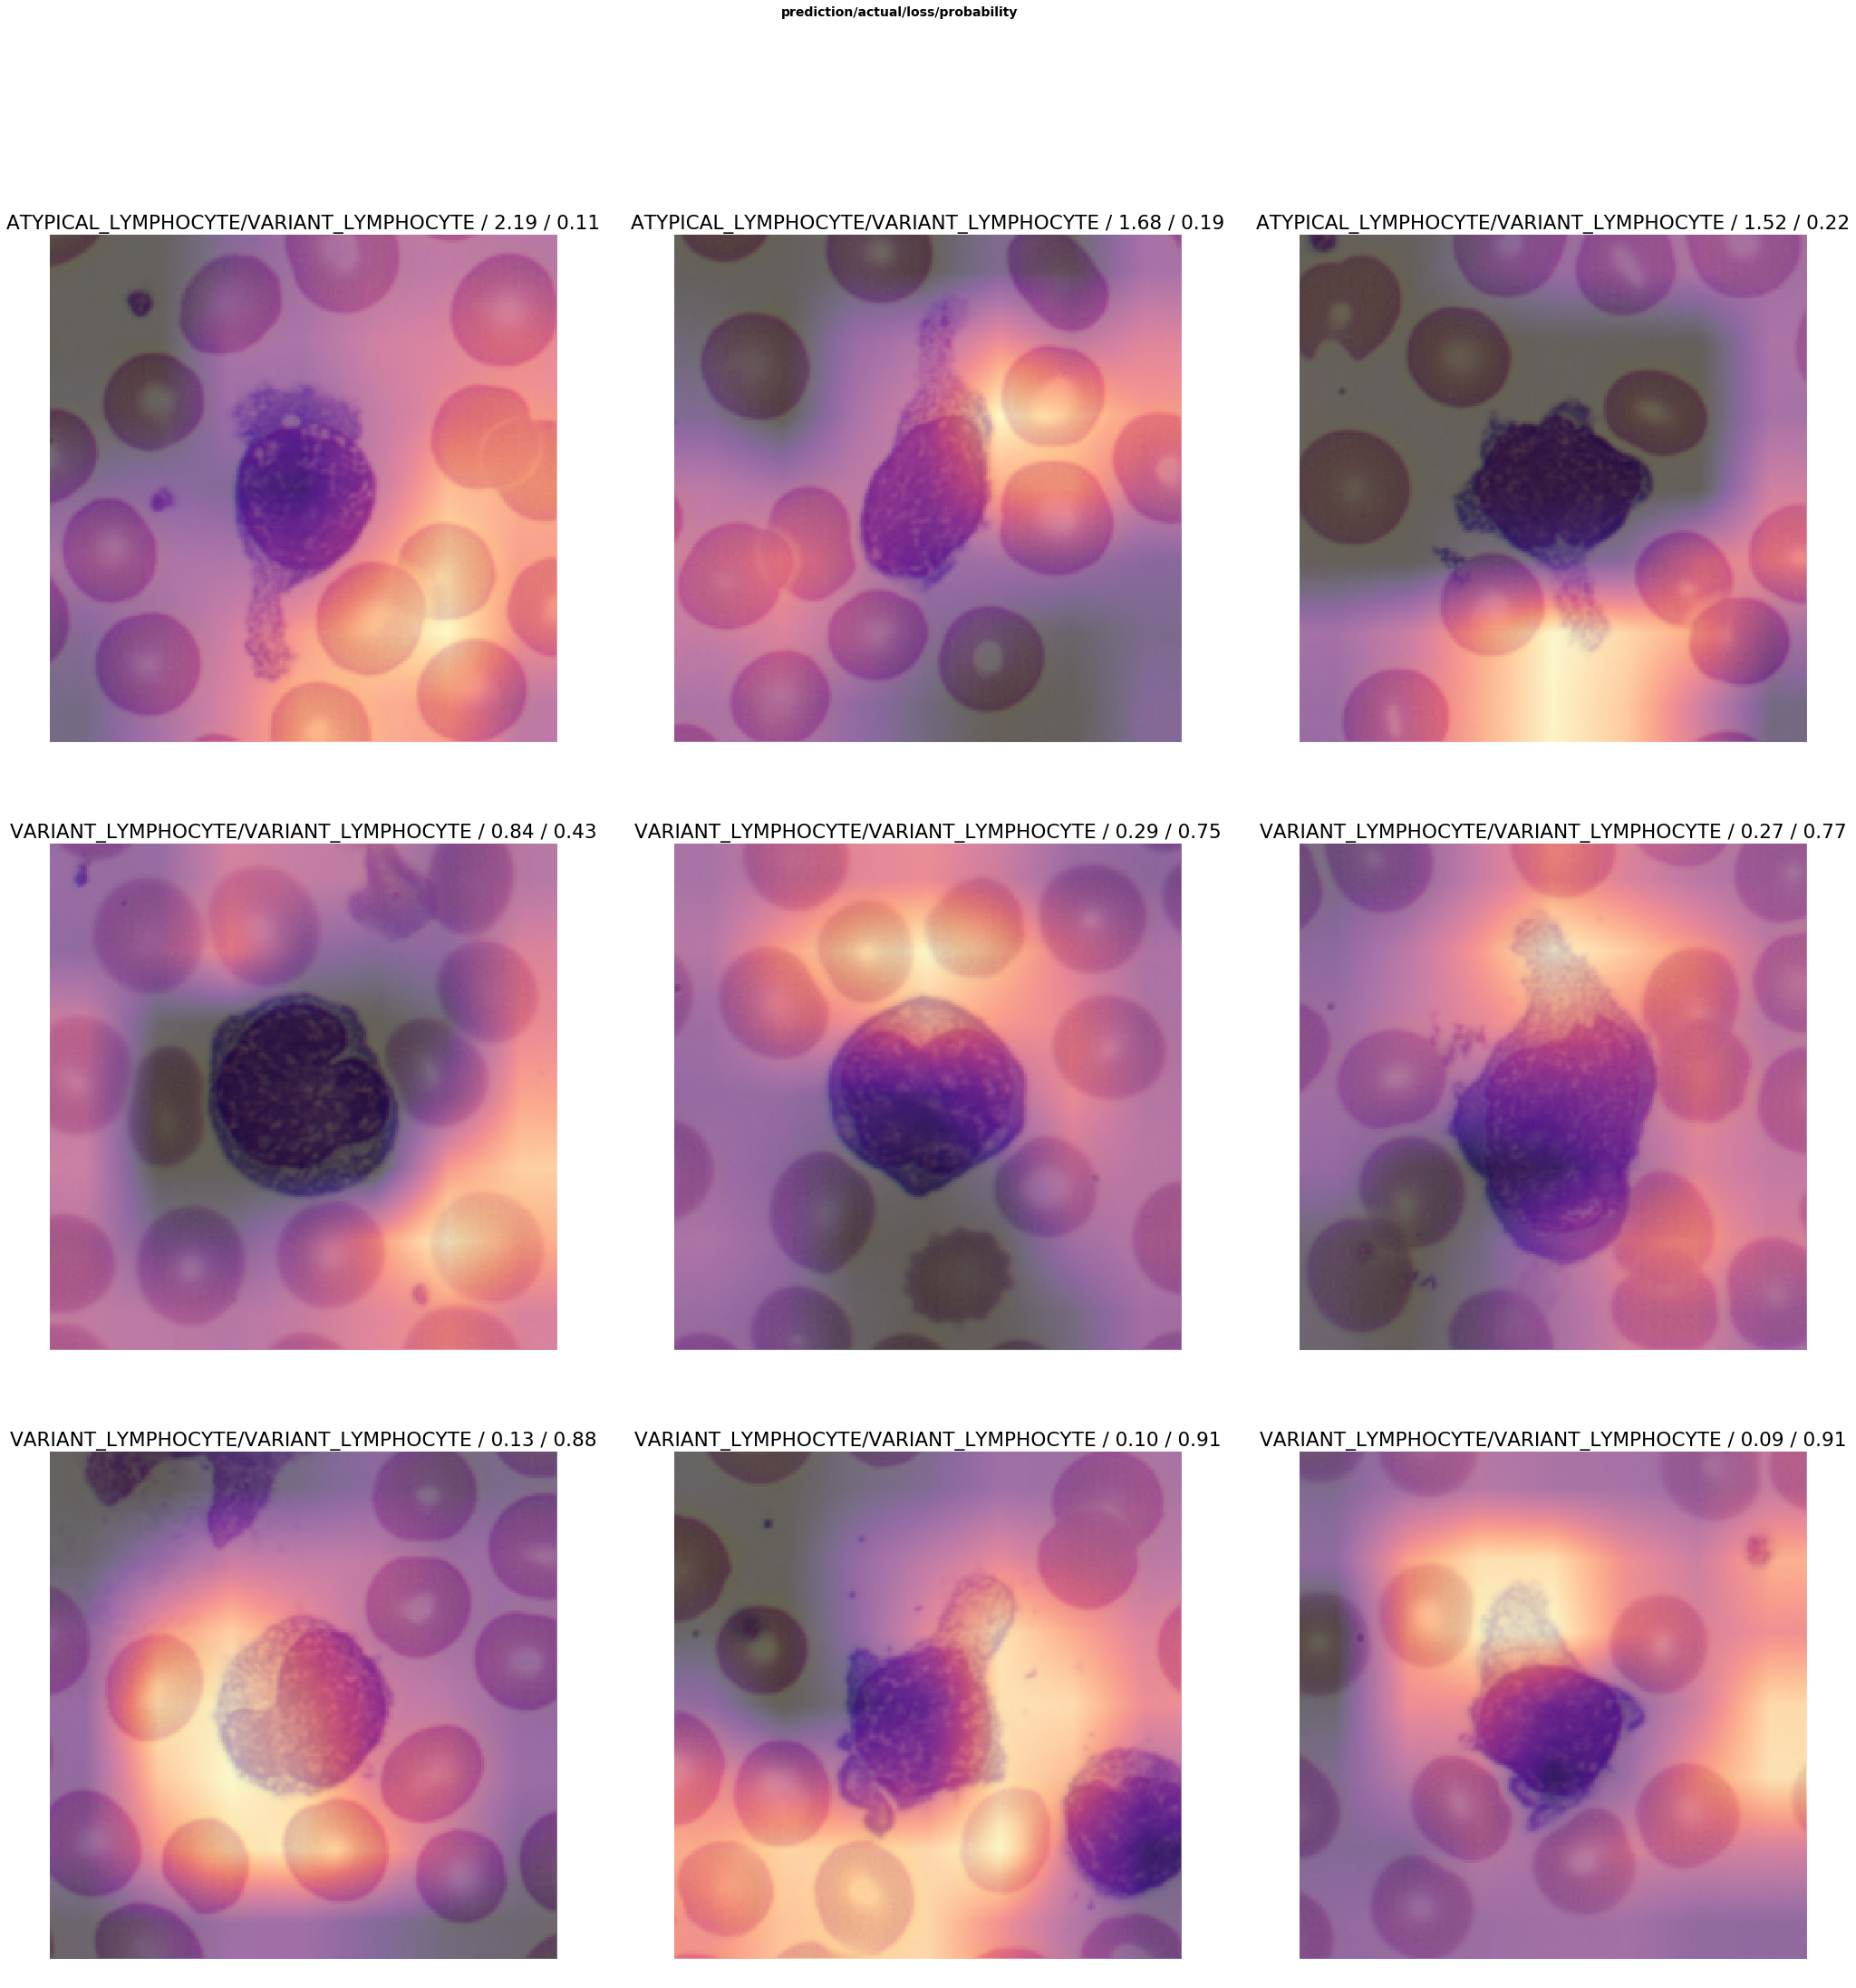

In [30]:
interp.plot_top_losses(9, largest=True, figsize=(35,35))


